# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 3, #degree
        'n': 5, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 5,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 50000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'border_min': 0.2, #needs to be between 0 and (x_max-x_min)/2
        'border_max': 0.4,
        'lower_degree_prob': 0.5,
        'a_zero_prob': 0.25,
        'a_random_prob': 0.1,      
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 50000,
                
        'interpretation_net_output_monomials': 5, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': False,
        'inet_training_without_noise': False, #dataset size without noise hardcoded to 50k in generate_paths
        'sparse_poly_representation_version': 1, #(1, 2); 1=old, 2=new

        'evaluate_with_real_function': False, #False
        'consider_labels_training': False, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        
        'symbolic_metamodeling_evaluation': True,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        'symbolic_regression_evaluation': True,
        'per_network_evaluation': True,
    },
    'computation':{
        'n_jobs': 20,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex, clear_output



In [4]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [5]:
from utilities.utility_functions import flatten, rec_gen, gen_monomial_identifier_list

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)     
        
    list_of_monomial_identifiers = []
    for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
        if np.sum(monomial_identifier) <= d:
            if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
                list_of_monomial_identifiers.append(monomial_identifier)        
else:
    variable_list = ['x'+ str(i) for i in range(n)]
    list_of_monomial_identifiers = gen_monomial_identifier_list(variable_list, d, n)
            
print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 56
[[3, 0, 0, 0, 0], [2, 1, 0, 0, 0], [2, 0, 1, 0, 0], [2, 0, 0, 1, 0], [2, 0, 0, 0, 1], [2, 0, 0, 0, 0], [1, 2, 0, 0, 0], [1, 1, 1, 0, 0], [1, 1, 0, 1, 0], [1, 1, 0, 0, 1], [1, 1, 0, 0, 0], [1, 0, 2, 0, 0], [1, 0, 1, 1, 0], [1, 0, 1, 0, 1], [1, 0, 1, 0, 0], [1, 0, 0, 2, 0], [1, 0, 0, 1, 1], [1, 0, 0, 1, 0], [1, 0, 0, 0, 2], [1, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 3, 0, 0, 0], [0, 2, 1, 0, 0], [0, 2, 0, 1, 0], [0, 2, 0, 0, 1], [0, 2, 0, 0, 0], [0, 1, 2, 0, 0], [0, 1, 1, 1, 0], [0, 1, 1, 0, 1], [0, 1, 1, 0, 0], [0, 1, 0, 2, 0], [0, 1, 0, 1, 1], [0, 1, 0, 1, 0], [0, 1, 0, 0, 2], [0, 1, 0, 0, 1], [0, 1, 0, 0, 0], [0, 0, 3, 0, 0], [0, 0, 2, 1, 0], [0, 0, 2, 0, 1], [0, 0, 2, 0, 0], [0, 0, 1, 2, 0], [0, 0, 1, 1, 1], [0, 0, 1, 1, 0], [0, 0, 1, 0, 2], [0, 0, 1, 0, 1], [0, 0, 1, 0, 0], [0, 0, 0, 3, 0], [0, 0, 0, 2, 1], [0, 0, 0, 2, 0], [0, 0, 0, 1, 2], [0, 0, 0, 1, 1], [0, 0, 0, 1, 0], [0, 0, 0, 0, 3], [0, 0, 0, 0, 2], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0]]


In [6]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials'] if config['i_net']['sparse_poly_representation_version'] == 1 else config['data']['n']*(config['data']['d']+1)*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']  
print('Output Shape: ', config['i_net']['interpretation_net_output_shape'])

transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

Output Shape:  285


In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_285_drop0.25e500b256_custom/lnets_50000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_5_d_3_negd_0_prob_0_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1
lnets_50000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_5_d_3_negd_0_prob_0_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [9]:
def load_lambda_nets(index, no_noise=False):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path_identifier_lambda_net_data_loading = None 
                
    if no_noise==True:
        path_identifier_lambda_net_data_loading = generate_paths(path_type='interpretation_net_no_noise')['path_identifier_lambda_net_data']
    else:
        path_identifier_lambda_net_data_loading = path_identifier_lambda_net_data 
        
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [10]:
#LOAD DATA
if inet_training_without_noise:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list_without_noise = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1, no_noise=True) for i in epochs_save_range_lambda)  
    del parallel
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
else:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=20)]: Using backend MultiprocessingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:  3.4min finished


## Data Inspection

In [11]:
lambda_net_dataset.as_pandas().head()

seed  30000-target  21000-target  20100-target  20010-target  \
33553  1373158606         0.000         0.000         0.000         0.730   
9427   1373158606         0.000         0.000         0.000         0.000   
199    1373158606         0.000         0.000         0.000         0.000   
12447  1373158606         0.000         0.000         0.000         0.040   
39489  1373158606         0.701         0.000         0.000         0.000   

       20001-target  20000-target  12000-target  11100-target  11010-target  \
33553         0.000         0.000         0.000         0.000         0.000   
9427          0.000         0.248         0.000         0.000         0.000   
199           0.000         0.000         0.000         0.000         0.000   
12447         0.000         0.000         0.000         0.000         0.000   
39489         0.000         0.000         0.000         0.000         0.000   

       11001-target  11000-target  10200-target  10110-target  10101-target  \
33553         0.760         0.000         0.000         0.000         0.000   
9427          0.000         0.243         0.000         0.000         0.052   
199           0.000         0.000         0.000         0.000         0.000   
12447         0.000         0.000        -0.624         0.000         0.000   
39489         0.000         0.000         0.000         0.000         0.000   

       10100-target  10020-target  10011-target  10010-target  10002-target  \
33553         0.000         0.000         0.000         0.000         0.000   
9427          0.000         0.817         0.000         0.000         0.000   
199           0.000         0.000         0.000         0.000         0.000   
12447         0.000         0.000         0.000         0.000         0.000   
39489         0.000         0.000         0.000         0.000         0.000   

       10001-target  10000-target  03000-target  02100-target  02010-target  \
33553         0.000         0.000         0.000         0.851         0.000   
9427          0.000         0.000         0.000         0.000         0.000   
199           0.000         0.000         0.000         0.000         0.000   
12447         0.000         0.000         0.000         0.000         0.000   
39489         0.000         0.000         0.000         0.000         0.000   

       02001-target  02000-target  01200-target  01110-target  01101-target  \
33553         0.000         0.000         0.000         0.000         0.000   
9427          0.000         0.000         0.000         0.000         0.000   
199          -0.028        -0.828         0.000         0.000         0.000   
12447         0.000        -0.808         0.000         0.000         0.000   
39489         0.000         0.000         0.000         0.000        -0.495   

       01100-target  01020-target  01011-target  01010-target  01002-target  \
33553         0.000         0.000         0.000         0.000         0.000   
9427          0.000         0.000         0.000         0.000         0.000   
199           0.000         0.000         0.000         0.000         0.000   
12447         0.000         0.000         0.000         0.000         0.000   
39489         0.856         0.000         0.000         0.000         0.290   

       01001-target  01000-target  00300-target  00210-target  00201-target  \
33553         0.000         0.000         0.000         0.000         0.000   
9427          0.000         0.000         0.000         0.000         0.000   
199           0.000         0.000         0.000         0.000         0.000   
12447         0.000         0.000         0.000         0.000         0.000   
39489         0.000         0.000         0.000         0.000         0.000   

       00200-target  00120-target  00111-target  00110-target  00102-target  \
33553         0.000         0.000         0.833         0.000         0.000   
9427          0.000         0.000         0.000         0.000      

In [12]:
lambda_net_dataset.as_pandas().describe()

seed  30000-target  21000-target  20100-target  20010-target  \
count      50000.000     50000.000     50000.000     50000.000     50000.000   
mean  1373158606.000         0.001         0.001        -0.001        -0.000   
std            0.000         0.172         0.173         0.174         0.172   
min   1373158606.000        -1.000        -0.999        -0.999        -1.000   
25%   1373158606.000         0.000         0.000         0.000         0.000   
50%   1373158606.000         0.000         0.000         0.000         0.000   
75%   1373158606.000         0.000         0.000         0.000         0.000   
max   1373158606.000         1.000         1.000         0.999         1.000   

       20001-target  20000-target  12000-target  11100-target  11010-target  \
count     50000.000     50000.000     50000.000     50000.000     50000.000   
mean          0.000        -0.000         0.000         0.000         0.002   
std           0.172         0.174         0.173         0.173         0.172   
min          -1.000        -1.000        -1.000        -1.000        -1.000   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           1.000         1.000         1.000         1.000         0.999   

       11001-target  11000-target  10200-target  10110-target  10101-target  \
count     50000.000     50000.000     50000.000     50000.000     50000.000   
mean          0.001         0.002        -0.001         0.001        -0.001   
std           0.172         0.174         0.172         0.172         0.170   
min          -1.000        -1.000        -0.999        -1.000        -0.999   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           0.999         1.000         1.000         0.999         1.000   

       10100-target  10020-target  10011-target  10010-target  10002-target  \
count     50000.000     50000.000     50000.000     50000.000     50000.000   
mean         -0.001        -0.000         0.001        -0.001        -0.000   
std           0.172         0.173         0.172         0.174         0.171   
min          -1.000        -0.999        -0.999        -1.000        -1.000   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           0.999         0.999         0.999         1.000         1.000   

       10001-target  10000-target  03000-target  02100-target  02010-target  \
count     50000.000     50000.000     50000.000     50000.000     50000.000   
mean          0.001        -0.000         0.000        -0.000        -0.000   
std           0.171         0.170         0.169         0.173         0.176   
min          -0.999        -1.000        -1.000        -0.999        -0.999   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           1.000         0.999         1.000         1.000         1.000   

       02001-target  02000-target  01200-target  01110-target  01101-target  \
count     50000.000     50000.000     50000.000     50000.000     50000.000   
mean          0.001        -0.001         0.001        -0.000         0.000   
std           0.175         0.174         0.170         0.171         0.172   
min          -0.999        -0.999        -1.000        -1.000        -1.000   
25%           0.000         0.000         0.000     

In [13]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.54307073, 0.52831733, 0.5149916 , 0.16620938, 0.0081753 ],
       [0.94684669, 0.14911355, 0.87066113, 0.46747354, 0.98108625],
       [0.18356603, 0.86695538, 0.04188025, 0.43317004, 0.24222806],
       [0.61834065, 0.6652858 , 0.50605354, 0.19238834, 0.5688891 ],
       [0.86536901, 0.59562369, 0.63892025, 0.94519601, 0.019919  ],
       [0.74220778, 0.1766805 , 0.12691774, 0.03118107, 0.95578408],
       [0.80017833, 0.40477786, 0.79646973, 0.49443804, 0.24891833],
       [0.14178731, 0.65313396, 0.1204457 , 0.25281736, 0.95570501],
       [0.53869236, 0.09357209, 0.59695428, 0.96801544, 0.73240838],
       [0.23055807, 0.15042731, 0.57401599, 0.48045005, 0.90620049]])

In [14]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[0.23739301],
       [1.57904804],
       [0.1219358 ],
       [0.58495724],
       [1.10469222],
       [0.85525787],
       [0.65731239],
       [1.17191768],
       [1.28775179],
       [0.84344   ]])

## Generate Datasets for Interpretation-Net training

In [15]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []


if inet_training_without_noise:
   
    for lambda_net_dataset, lambda_net_dataset_without_noise in zip(lambda_net_dataset_list, lambda_net_dataset_list_without_noise):
        if inet_holdout_seed_evaluation:
            raise SystemExit('Holdout Evaluation not implemented with inet training without noise')
            
        else:
            lambda_net_train_dataset = lambda_net_dataset_without_noise

            lambda_net_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_dataset_list_without_noise
        
else:

    for lambda_net_dataset in lambda_net_dataset_list:

        if inet_holdout_seed_evaluation:

            complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

            random.seed(RANDOM_SEED)

            if isinstance(test_size, float):
                test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))

            test_seeds = random.sample(complete_seed_list, test_size)
            lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

            random.seed(RANDOM_SEED)
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
            lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

            train_seeds = complete_seed_list
            lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset
        else:

            lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_train_with_valid_dataset


del lambda_net_dataset_list

In [16]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(44910, 345)

In [17]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(4990, 345)

In [18]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 345)

In [19]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  30000-target  21000-target  20100-target  20010-target  \
9901   1373158606         0.000         0.000         0.000         0.000   
5910   1373158606         0.000         0.000         0.000         0.000   
18619  1373158606         0.000         0.000         0.000         0.000   
33312  1373158606        -0.606         0.000         0.000         0.000   
47430  1373158606         0.000         0.000         0.000         0.000   

       20001-target  20000-target  12000-target  11100-target  11010-target  \
9901          0.000         0.000         0.371         0.000         0.000   
5910          0.000         0.000         0.000         0.000         0.000   
18619         0.739         0.000         0.000         0.000         0.000   
33312         0.000         0.017         0.000         0.000         0.000   
47430         0.000         0.000         0.000         0.000         0.000   

       11001-target  11000-target  10200-target  10110-target  10101-target  \
9901          0.000         0.000         0.000         0.000         0.000   
5910          0.000         0.000         0.000         0.246         0.000   
18619         0.000         0.000         0.000         0.000         0.000   
33312         0.000         0.000         0.000         0.000         0.000   
47430         0.000         0.000         0.000         0.000         0.437   

       10100-target  10020-target  10011-target  10010-target  10002-target  \
9901          0.000         0.000         0.000         0.000         0.000   
5910          0.000         0.000         0.000         0.000         0.000   
18619         0.000         0.000         0.000         0.557         0.000   
33312         0.000         0.000         0.201         0.000         0.000   
47430         0.862         0.000         0.000         0.000         0.000   

       10001-target  10000-target  03000-target  02100-target  02010-target  \
9901          0.000         0.000         0.000         0.000         0.000   
5910          0.000         0.241         0.000        -0.620         0.000   
18619         0.000         0.000         0.000         0.000         0.000   
33312         0.000         0.000         0.000         0.000         0.000   
47430         0.000         0.000         0.000         0.000         0.805   

       02001-target  02000-target  01200-target  01110-target  01101-target  \
9901          0.000         0.000         0.000         0.000         0.000   
5910          0.000         0.000         0.000         0.000         0.000   
18619         0.711         0.000         0.000         0.000         0.000   
33312         0.000         0.000         0.000         0.000         0.000   
47430         0.000         0.000         0.000         0.000         0.000   

       01100-target  01020-target  01011-target  01010-target  01002-target  \
9901         -0.022         0.000         0.000         0.000         0.000   
5910          0.000         0.000         0.000         0.000         0.000   
18619         0.427         0.000         0.000         0.000         0.000   
33312         0.000         0.000         0.000         0.000         0.000   
47430         0.000         0.000         0.000         0.000         0.000   

       01001-target  01000-target  00300-target  00210-target  00201-target  \
9901          0.000         0.594         0.000         0.000         0.000   
5910          0.000         0.000         0.000         0.000         0.000   
18619         0.000         0.000         0.000         0.000         0.000   
33312         0.000         0.000         0.000         0.000         0.000   
47430         0.000         0.000         0.000         0.000         0.000   

       00200-target  00120-target  00111-target  00110-target  00102-target  \
9901          0.000         0.705         0.000         0.000         0.000   
5910          0.000         0.000         0.000         0.000      

In [20]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  30000-target  21000-target  20100-target  20010-target  \
7038   1373158606        -0.961         0.995         0.000         0.000   
30770  1373158606         0.000         0.000         0.000         0.000   
41342  1373158606         0.000        -0.874         0.000         0.000   
21084  1373158606         0.000         0.000         0.000         0.000   
47211  1373158606         0.000         0.000         0.000         0.000   

       20001-target  20000-target  12000-target  11100-target  11010-target  \
7038          0.000         0.000         0.000         0.000         0.000   
30770         0.000         0.000         0.000         0.000         0.000   
41342         0.000         0.000         0.000         0.000         0.288   
21084         0.000         0.000         0.000         0.000         0.000   
47211         0.000         0.000         0.000         0.000         0.000   

       11001-target  11000-target  10200-target  10110-target  10101-target  \
7038          0.000         0.000         0.000         0.000         0.000   
30770         0.000         0.499         0.000         0.000         0.000   
41342         0.000         0.000         0.000         0.000         0.000   
21084         0.000         0.000         0.000         0.000         0.000   
47211        -0.859         0.000         0.000         0.000        -0.603   

       10100-target  10020-target  10011-target  10010-target  10002-target  \
7038          0.000         0.000         0.000         0.000         0.000   
30770         0.000         0.000         0.000         0.000         0.000   
41342         0.000         0.000         0.000         0.000         0.000   
21084         0.000         0.000         0.000         0.000         0.000   
47211         0.000         0.000         0.000         0.000         0.000   

       10001-target  10000-target  03000-target  02100-target  02010-target  \
7038          0.000         0.273         0.000         0.000         0.000   
30770         0.000         0.000         0.000         0.000         0.000   
41342         0.000        -0.212         0.000         0.000         0.000   
21084         0.000         0.327         0.000         0.000         0.000   
47211         0.000         0.000         0.000         0.000         0.000   

       02001-target  02000-target  01200-target  01110-target  01101-target  \
7038          0.000         0.000         0.000         0.000         0.000   
30770         0.000         0.000         0.319        -0.514         0.000   
41342         0.000         0.000         0.000         0.000         0.000   
21084         0.113         0.000         0.000         0.000         0.000   
47211         0.000         0.000         0.000         0.000         0.137   

       01100-target  01020-target  01011-target  01010-target  01002-target  \
7038          0.000         0.000         0.000         0.000         0.000   
30770         0.000         0.000         0.000         0.000         0.000   
41342         0.000         0.000         0.000         0.000         0.000   
21084         0.000        -0.691         0.000         0.000         0.000   
47211         0.000         0.000         0.000         0.000         0.000   

       01001-target  01000-target  00300-target  00210-target  00201-target  \
7038          0.000        -0.098         0.000         0.000         0.000   
30770         0.000         0.000         0.000         1.000         0.000   
41342         0.000         0.000         0.000         0.000         0.000   
21084         0.000         0.000         0.000         0.000         0.000   
47211         0.000         0.885         0.000         0.000         0.000   

       00200-target  00120-target  00111-target  00110-target  00102-target  \
7038          0.000        -0.378         0.000         0.000         0.000   
30770         0.000         0.000         0.000         0.000      

In [21]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  30000-target  21000-target  20100-target  20010-target  \
35587  1373158606         0.000         0.000         0.000         0.000   
32681  1373158606         0.000         0.000         0.000         0.000   
40971  1373158606         0.000        -0.461         0.000         0.000   
21022  1373158606         0.000         0.000         0.000         0.907   
6403   1373158606         0.000         0.000         0.000        -0.558   

       20001-target  20000-target  12000-target  11100-target  11010-target  \
35587         0.000         0.953         0.000         0.000         0.000   
32681         0.000         0.000         0.000         0.000         0.000   
40971         0.000         0.000         0.000         0.000         0.000   
21022         0.000         0.000         0.000         0.000         0.000   
6403          0.118         0.652         0.000         0.000         0.000   

       11001-target  11000-target  10200-target  10110-target  10101-target  \
35587         0.000         0.000         0.000         0.000         0.000   
32681         0.000         0.000         0.000         0.000         0.000   
40971         0.000         0.000        -0.872         0.000         0.000   
21022         0.000         0.000         0.000         0.000         0.000   
6403          0.000         0.000         0.000         0.000         0.000   

       10100-target  10020-target  10011-target  10010-target  10002-target  \
35587         0.000         0.000         0.000         0.000         0.367   
32681         0.000         0.000         0.000         0.000        -0.928   
40971         0.000         0.000         0.000         0.000         0.000   
21022         0.000         0.000         0.000         0.000         0.000   
6403          0.000         0.000         0.000         0.000         0.000   

       10001-target  10000-target  03000-target  02100-target  02010-target  \
35587         0.000         0.000         0.000         0.000         0.000   
32681         0.000         0.000         0.000         0.000         0.000   
40971         0.000         0.000         0.000         0.000         0.000   
21022         0.000         0.000         0.000         0.000         0.000   
6403          0.000         0.000         0.000         0.000         0.000   

       02001-target  02000-target  01200-target  01110-target  01101-target  \
35587         0.000         0.000         0.000         0.000         0.000   
32681         0.000         0.000         0.560         0.000         0.000   
40971         0.000         0.000         0.000         0.000         0.000   
21022         0.000         0.000         0.321         0.000         0.773   
6403          0.907         0.000         0.000         0.000         0.000   

       01100-target  01020-target  01011-target  01010-target  01002-target  \
35587         0.000         0.000         0.594         0.000        -0.622   
32681         0.000         0.000         0.000         0.000         0.000   
40971         0.000         0.000         0.000         0.000         0.000   
21022         0.000         0.000        -0.501         0.000         0.000   
6403          0.000         0.000         0.000         0.000         0.000   

       01001-target  01000-target  00300-target  00210-target  00201-target  \
35587         0.000         0.000         0.000         0.000         0.000   
32681         0.000         0.000         0.000         0.000         0.000   
40971         0.000         0.000         0.000         0.000         0.000   
21022         0.000         0.000         0.000         0.000         0.401   
6403          0.000         0.000         0.000         0.000         0.000   

       00200-target  00120-target  00111-target  00110-target  00102-target  \
35587         0.371         0.000         0.000         0.000         0.000   
32681         0.000         0.772         0.000         0.000      

## Interpretation Network Training

In [22]:
#%load_ext autoreload

In [23]:
#%autoreload 2
(history_list, 

#scores_valid_list,
scores_test_list, 

#function_values_valid_list, 
function_values_test_list, 

#polynomial_dict_valid_list,
polynomial_dict_test_list,

#distrib_dict_valid_list,
distrib_dict_test_list,

model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)



----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Epoch 1/500
176/176 [==============================] - 34s 170ms/step - loss: 0.2657 - r2_inet_lambda_fv_loss: 1.0776 - val_loss: 0.2132 - val_r2_inet_lambda_fv_loss: 0.2762
Epoch 2/500
176/176 [==============================] - 27s 151ms/step - loss: 0.2206 - r2_inet_lambda_fv_loss: 0.3743 - val_loss: 0.2070 - val_r2_inet_lambda_fv_loss: 0.1766
Epoch 3/500
176/176 [==============================] - 27s 151ms/step - loss: 0.2136 - r2_inet_lambda_fv_loss: 0.2603 - val_loss: 0.2057 - val_r2_inet_lambda_fv_loss: 0.1337
Epoch 4/500
176/176 [==============================] - 27s 151ms/step - loss: 0.2116 - r2_inet_lambda_fv_loss: 0.2319 - val_loss: 0.2012 - val_r2_inet_lambda_fv_loss: 0.0732
Epoch 5/500
176/176 [==============================] - 27s 151ms/step - loss: 0.2080 - r2_inet_lambda_fv_loss: 0.1770 - val_loss: 0.2010 - val_r2_inet_lambda_fv_loss: 0.0727
Epoch 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



176/176 [==============================] - 26s 150ms/step - loss: 0.1746 - r2_inet_lambda_fv_loss: -0.1776 - val_loss: 0.1709 - val_r2_inet_lambda_fv_loss: -0.2209
Epoch 42/500
176/176 [==============================] - 26s 149ms/step - loss: 0.1739 - r2_inet_lambda_fv_loss: -0.1851 - val_loss: 0.1719 - val_r2_inet_lambda_fv_loss: -0.2038
Epoch 43/500
176/176 [==============================] - 26s 150ms/step - loss: 0.1732 - r2_inet_lambda_fv_loss: -0.1814 - val_loss: 0.1696 - val_r2_inet_lambda_fv_loss: -0.2338
Epoch 44/500
176/176 [==============================] - 26s 150ms/step - loss: 0.1732 - r2_inet_lambda_fv_loss: -0.1872 - val_loss: 0.1683 - val_r2_inet_lambda_fv_loss: -0.2493
Epoch 45/500
176/176 [==============================] - 26s 149ms/step - loss: 0.1716 - r2_inet_lambda_fv_loss: -0.2147 - val_loss: 0.1693 - val_r2_inet_lambda_fv_loss: -0.2308
Epoch 46/500
176/176 [==============================] - 26s 150ms/step - loss: 0.1712 - r2_inet_lambda_fv_loss: -0.2150 - val_lo

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



176/176 [==============================] - 26s 150ms/step - loss: 0.1636 - r2_inet_lambda_fv_loss: -0.2898 - val_loss: 0.1636 - val_r2_inet_lambda_fv_loss: -0.2880
Epoch 89/500
176/176 [==============================] - 26s 150ms/step - loss: 0.1638 - r2_inet_lambda_fv_loss: -0.2827 - val_loss: 0.1630 - val_r2_inet_lambda_fv_loss: -0.2986
Epoch 90/500
176/176 [==============================] - 26s 149ms/step - loss: 0.1639 - r2_inet_lambda_fv_loss: -0.2838 - val_loss: 0.1609 - val_r2_inet_lambda_fv_loss: -0.3167
Epoch 91/500
176/176 [==============================] - 26s 149ms/step - loss: 0.1620 - r2_inet_lambda_fv_loss: -0.3031 - val_loss: 0.1606 - val_r2_inet_lambda_fv_loss: -0.3199
Epoch 92/500
176/176 [==============================] - 26s 149ms/step - loss: 0.1615 - r2_inet_lambda_fv_loss: -0.3102 - val_loss: 0.1597 - val_r2_inet_lambda_fv_loss: -0.3248
Epoch 93/500
176/176 [==============================] - 26s 149ms/step - loss: 0.1612 - r2_inet_lambda_fv_loss: -0.3032 - val_lo

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



176/176 [==============================] - 26s 150ms/step - loss: 0.1540 - r2_inet_lambda_fv_loss: -0.3016 - val_loss: 0.1543 - val_r2_inet_lambda_fv_loss: -0.3311
Epoch 133/500
176/176 [==============================] - 26s 150ms/step - loss: 0.1541 - r2_inet_lambda_fv_loss: -0.3241 - val_loss: 0.1529 - val_r2_inet_lambda_fv_loss: -0.3346
Epoch 134/500
176/176 [==============================] - 26s 149ms/step - loss: 0.1532 - r2_inet_lambda_fv_loss: -0.3300 - val_loss: 0.1528 - val_r2_inet_lambda_fv_loss: -0.3391
Epoch 135/500
176/176 [==============================] - 26s 150ms/step - loss: 0.1527 - r2_inet_lambda_fv_loss: -0.3138 - val_loss: 0.1527 - val_r2_inet_lambda_fv_loss: -0.3394
Epoch 136/500
176/176 [==============================] - 26s 149ms/step - loss: 0.1528 - r2_inet_lambda_fv_loss: -0.2837 - val_loss: 0.1527 - val_r2_inet_lambda_fv_loss: -0.3508
Epoch 137/500
176/176 [==============================] - 26s 149ms/step - loss: 0.1521 - r2_inet_lambda_fv_loss: -0.3264 - v

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



176/176 [==============================] - 26s 150ms/step - loss: 0.1487 - r2_inet_lambda_fv_loss: -0.3140 - val_loss: 0.1514 - val_r2_inet_lambda_fv_loss: -0.3113
Epoch 179/500
176/176 [==============================] - 26s 150ms/step - loss: 0.1486 - r2_inet_lambda_fv_loss: -0.3290 - val_loss: 0.1495 - val_r2_inet_lambda_fv_loss: -0.3452
Epoch 180/500
176/176 [==============================] - 26s 149ms/step - loss: 0.1477 - r2_inet_lambda_fv_loss: -0.3428 - val_loss: 0.1493 - val_r2_inet_lambda_fv_loss: -0.3450
Epoch 181/500
176/176 [==============================] - 26s 150ms/step - loss: 0.1483 - r2_inet_lambda_fv_loss: -0.3305 - val_loss: 0.1501 - val_r2_inet_lambda_fv_loss: -0.3408
Epoch 182/500
176/176 [==============================] - 26s 149ms/step - loss: 0.1479 - r2_inet_lambda_fv_loss: -0.3384 - val_loss: 0.1508 - val_r2_inet_lambda_fv_loss: -0.3332
Epoch 183/500
176/176 [==============================] - 26s 149ms/step - loss: 0.1484 - r2_inet_lambda_fv_loss: -0.3409 - v

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Evaluate Interpretation Net

In [24]:
%tb

No traceback available to show.


In [25]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [26]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 176)]        0                                            
__________________________________________________________________________________________________
hidden1_512 (Dense)             (None, 512)          90624       input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 512)          0           hidden1_512[0][0]                
__________________________________________________________________________________________________
dropout1_0.25 (Dropout)         (None, 512)          0           activation1_relu[0][0]           
______________________________________________________________________________________________

In [27]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [28]:
scores_test_list[-1]

MAE    RMSE     MAPE  \
lambda_preds_VS_target_polynomials                     NaN     NaN      NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials          NaN     NaN      NaN   
lambda_preds_VS_lstsq_target_polynomials               NaN     NaN      NaN   
lambda_preds_VS_inet_polynomials                       NaN     NaN      NaN   
lambda_preds_VS_metamodel_functions                    NaN     NaN      NaN   
lambda_preds_VS_symbolic_regression_functions          NaN     NaN      NaN   
lambda_preds_VS_per_network_polynomials                NaN     NaN      NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...   0.061   0.091    5.182   
target_polynomials_VS_lstsq_target_polynomials       0.000   0.000    0.000   
target_polynomials_VS_inet_polynomials               0.321   0.444   28.125   
target_polynomials_VS_metamodel_functions              NaN     NaN      NaN   
target_polynomials_VS_symbolic_regression_funct...     NaN     NaN      NaN   
target_polynomials_VS_per_network_polynomials        0.578   0.740   52.484   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...   0.061   0.091    4.727   
lstsq_lambda_pred_polynomials_VS_inet_polynomials    0.324   0.442   27.305   
lstsq_lambda_pred_polynomials_VS_metamodel_func...     NaN     NaN      NaN   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...     NaN     NaN      NaN   
lstsq_lambda_pred_polynomials_VS_per_network_po...   0.576   0.744   32.220   
lstsq_target_polynomials_VS_inet_polynomials         0.321   0.444   28.125   
lstsq_target_polynomials_VS_metamodel_functions        NaN     NaN      NaN   
lstsq_target_polynomials_VS_symbolic_regression...     NaN     NaN      NaN   
lstsq_target_polynomials_VS_per_network_polynom...   0.578   0.740   52.484   
inet_polynomials_VS_metamodel_functions                NaN     NaN      NaN   
inet_polynomials_VS_symbolic_regression_functions      NaN     NaN      NaN   
inet_polynomials_VS_per_network_polynomials        107.385 177.732 3885.632   
metamodel_functions_VS_symbolic_regression_func...     NaN     NaN      NaN   
metamodel_functions_VS_per_network_polynomials         NaN     NaN      NaN   
symbolic_regression_functions_VS_per_network_po...     NaN     NaN      NaN   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
lambda_preds_VS_metamodel_functions                      NaN   
lambda_preds_VS_symbolic_regression_functions            NaN   
lambda_preds_VS_per_network_polynomials                  NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.581   
target_polynomials_VS_lstsq_target_polynomials         1.000   
target_polynomials_VS_inet_polynomials                 0.156   
target_polynomials_VS_metamodel_functions                NaN   
target_polynomials_VS_symbolic_regression_funct...       NaN   
target_polynomials_VS_per_network_polynomials          0.058   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.581   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.138   
lstsq_lambda_pred_polynomials_VS_metamodel_func...       NaN   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...       NaN   
lstsq_lambda_pred_polynomials_VS_per_network_po...     0.052   
lstsq_target_polynomials_VS_inet_polynomials           0.156   
lstsq_target_polynomials_VS_metamodel_functions          NaN   
lstsq_target_polynomials_VS_symbolic_regression...       NaN   
lstsq_target_polynomials_VS_per_network_polynom...     0.058   
inet_polynomials_VS_metamodel_functions                  NaN   
inet_polynomials_VS_symbolic_regression_functions        NaN   
inet_polynomials_VS_per_network_polynomials            0.001   
metamodel_functions_VS_symbolic_regression_func...       NaN   
metamodel_functions_VS_per_network_

In [29]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.352 0.303 0.235 0.190   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.332 0.255 0.205 0.245   
lambda_preds_VS_lstsq_target_polynomials           0.352 0.303 0.235 0.190   
lambda_preds_VS_inet_polynomials                   0.106 0.116 0.145 0.147   
lambda_preds_VS_metamodel_functions                0.672 0.954 1.021 0.425   
lambda_preds_VS_symbolic_regression_functions      0.065 0.127 0.126 0.168   
lambda_preds_VS_per_network_polynomials            0.056 0.080 0.139 0.103   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.106 0.093 0.091 0.083   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.355 0.289 0.238 0.206   
target_polynomials_VS_metamodel_functions          0.561 1.201 0.821 0.367   
target_polynomials_VS_symbolic_regression_funct... 0.355 0.279 0.236 0.247   
target_polynomials_VS_per_network_polynomials      0.339 0.313 0.267 0.152   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.106 0.093 0.091 0.083   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.331 0.229 0.235 0.248   
lstsq_lambda_pred_polynomials_VS_metamodel_func... 0.547 1.137 0.881 0.412   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.336 0.225 0.200 0.281   
lstsq_lambda_pred_polynomials_VS_per_network_po... 0.319 0.272 0.231 0.199   
lstsq_target_polynomials_VS_inet_polynomials       0.355 0.289 0.238 0.206   
lstsq_target_polynomials_VS_metamodel_functions    0.561 1.201 0.821 0.367   
lstsq_target_polynomials_VS_symbolic_regression... 0.355 0.279 0.236 0.247   
lstsq_target_polynomials_VS_per_network_polynom... 0.339 0.313 0.267 0.152   
inet_polynomials_VS_metamodel_functions            0.704 0.930 0.954 0.401   
inet_polynomials_VS_symbolic_regression_functions  0.115 0.049 0.174 0.168   
inet_polynomials_VS_per_network_polynomials        0.100 0.104 0.184 0.131   
metamodel_functions_VS_symbolic_regression_func... 0.661 0.972 0.995 0.422   
metamodel_functions_VS_per_network_polynomials     0.678 0.938 1.025 0.396   
symbolic_regression_functions_VS_per_network_po... 0.032 0.102 0.190 0.157   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.241 0.126 0.350 0.331   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.222 0.239 0.308 0.356   
lambda_preds_VS_lstsq_target_polynomials           0.241 0.126 0.350 0.331   
lambda_preds_VS_inet_polynomials                   0.095 0.163 0.153 0.102   
lambda_preds_VS_metamodel_functions                0.228 0.801 1.165 0.663   
lambda_preds_VS_symbolic_regression_functions      0.116 0.123 0.116 0.092   
lambda_preds_VS_per_network_polynomials            0.071 0.057 0.158 0.062   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.055 0.180 0.058 0.043   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.172 0.105 0.315 0.342   
target_polynomials_VS_metamodel_functions          0.317 0.750 0.994 0.954   
target_polynomials_VS_symbolic_regression_funct... 0.223 0.199 0.338 0.368   
target_polynomials_VS_per_network_polynomials      0.224 0.139 0.280 0.337   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.055 0.180 0.058 0.043   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.160 0.245 0.279 0.371   
lstsq_lambda_pred_polynomials_VS_metamodel_func... 0.322 0.573 1.025 0.991   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.207 0.280 0.296 0.398   
lstsq_lambda_pred_polynomials_VS_per_network_po... 0.202 0.257 0.240 0.364   
lstsq_target_polynomials_VS_inet_polynomials       0.172 0.105 0.315 0.342   
lstsq_target_polynomials_VS_metamodel_functions    0.317 0.750 0.994 0.954   
lstsq_target_polynomials_VS_symbolic_regression... 0.223 0.199 0.338 0.368   
lstsq_target_polynomials_VS_per_network_polynom... 0.224 0.139 0.280 0.337

In [30]:
distrib_dict_test_list[-1]['R2']

L-0      L-1  \
lambda_preds_VS_target_polynomials                   -0.978   -4.146   
lambda_preds_VS_lstsq_lambda_pred_polynomials        -0.728   -2.608   
lambda_preds_VS_lstsq_target_polynomials             -0.978   -4.146   
lambda_preds_VS_inet_polynomials                      0.804    0.172   
lambda_preds_VS_metamodel_functions                  -4.413  -30.136   
lambda_preds_VS_symbolic_regression_functions         0.923    0.085   
lambda_preds_VS_per_network_polynomials               0.937    0.621   
target_polynomials_VS_lstsq_lambda_pred_polynom...    0.863    0.811   
target_polynomials_VS_lstsq_target_polynomials        1.000    1.000   
target_polynomials_VS_inet_polynomials               -0.697   -0.832   
target_polynomials_VS_metamodel_functions            -2.315  -19.650   
target_polynomials_VS_symbolic_regression_funct...   -0.614   -0.702   
target_polynomials_VS_per_network_polynomials        -0.490   -1.269   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...    0.832    0.755   
lstsq_lambda_pred_polynomials_VS_inet_polynomials    -0.761   -0.560   
lstsq_lambda_pred_polynomials_VS_metamodel_func...   -2.818  -22.843   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...   -0.760   -0.476   
lstsq_lambda_pred_polynomials_VS_per_network_po...   -0.611   -1.137   
lstsq_target_polynomials_VS_inet_polynomials         -0.697   -0.832   
lstsq_target_polynomials_VS_metamodel_functions      -2.315  -19.650   
lstsq_target_polynomials_VS_symbolic_regression...   -0.614   -0.702   
lstsq_target_polynomials_VS_per_network_polynom...   -0.490   -1.269   
inet_polynomials_VS_metamodel_functions              -3.809 -196.121   
inet_polynomials_VS_symbolic_regression_functions     0.800   -0.080   
inet_polynomials_VS_per_network_polynomials           0.856   -3.029   
metamodel_functions_VS_symbolic_regression_func... -239.371    0.000   
metamodel_functions_VS_per_network_polynomials     -248.213    0.000   
symbolic_regression_functions_VS_per_network_po...    0.974  -50.485   

                                                         L-2    L-3    L-4  \
lambda_preds_VS_target_polynomials                     0.382  0.150 -0.902   
lambda_preds_VS_lstsq_lambda_pred_polynomials          0.477 -0.264 -0.554   
lambda_preds_VS_lstsq_target_polynomials               0.382  0.150 -0.902   
lambda_preds_VS_inet_polynomials                       0.709  0.554  0.665   
lambda_preds_VS_metamodel_functions                   -8.451 -2.188 -0.556   
lambda_preds_VS_symbolic_regression_functions          0.770  0.420  0.542   
lambda_preds_VS_per_network_polynomials                0.701  0.739  0.806   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.896  0.851  0.904   
target_polynomials_VS_lstsq_target_polynomials         1.000  1.000  1.000   
target_polynomials_VS_inet_polynomials                 0.384 -0.074 -0.022   
target_polynomials_VS_metamodel_functions             -5.021 -2.060 -1.958   
target_polynomials_VS_symbolic_regression_funct...     0.427 -0.387 -0.565   
target_polynomials_VS_per_network_polynomials          0.299  0.366 -0.564   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.917  0.886  0.888   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.497 -0.128 -0.014   
lstsq_lambda_pred_polynomials_VS_metamodel_func...    -4.616 -2.099 -2.426   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...     0.622 -0.400 -0.511   
lstsq_lambda_pred_polynomials_VS_per_network_po...     0.535  0.243 -0.493   
lstsq_target_polynomials_VS_inet_polynomials           0.384 -0.074 -0.022   
lstsq_target_polynomials_VS_metamodel_functions       -5.021 -2.060 -1.958   
lstsq_target_polynomials_VS_symbolic_regression...     0.427 -0.387 -0.565   
lstsq_target_polynomials_VS_per_network_polynom...     0.299  0.366 -0.564   
inet_polynomials_VS_metamodel_functions              -11.699 -2.996 -0.535   
inet_polynomials_VS_symbolic_regression_functions      0.340  0.219  0.358   
inet_polynomials_

In [31]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))

print(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

-50.85698099486319


-0.649278724263991*a**3 + 0.0269569594787997*a**2*b - 0.0471965275518224*a**2*c + 0.0156290869176366*a**2*d + 0.0016099494232273*a**2*e + 0.0005526346847803*a**2 + 0.0315075623211754*a*b**2 + 0.0182122173645169*a*b*c - 0.0060336713280622*a*b*d - 0.0011249496909067*a*b*e - 0.127037954760422*a*b - 0.0004494184751322*a*c**2 - 0.0140107625764752*a*c*d - 0.0423566927495047*a*c*e - 0.0048673540671922*a*c + 0.0232186158067156*a*d**2 + 0.281884673013846*a*d*e - 0.0116256400192221*a*d - 0.0131031060558577*a*e**2 - 0.139721128990963*a*e - 0.0124026968166148*a - 0.0487484274238165*b**3 + 0.006750289892232*b**2*c - 0.0144597132056452*b**2*d - 0.0117995212210427*b**2*e + 0.0050279444058042*b**2 - 0.294903717163306*b*c**2 + 0.0057141041266497*b*c*d + 0.0239972793165836*b*c*e + 0.204722859121838*b*c - 0.0193304891203725*b*d**2 + 0.049246800167541*b*d*e + 0.0059723808627358*b*d - 0.0432452607731699*b*e**2 + 0.0115131782407366*b*e + 0.0605437911666774*b + 0.0106350231544896*c**3 + 0.0064246954989408*c*

In [32]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.4517803985534146 (100 Samples)
Mean (only positive): 0.51404929779121 (91 Samples)


In [33]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: -2.1962381688431023 (100 Samples)
Mean (only positive): 0.3522614008088732 (16 Samples)


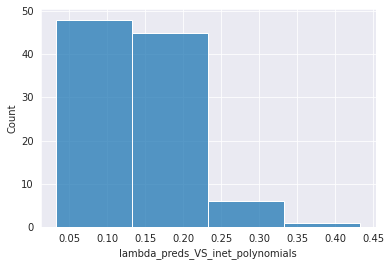

In [34]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

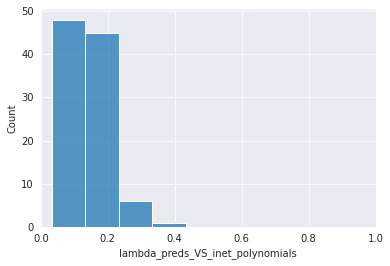

In [35]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


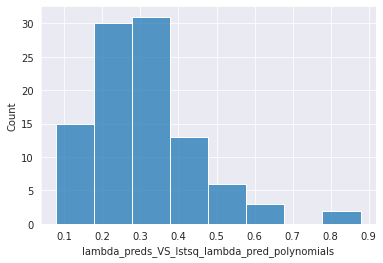

In [36]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

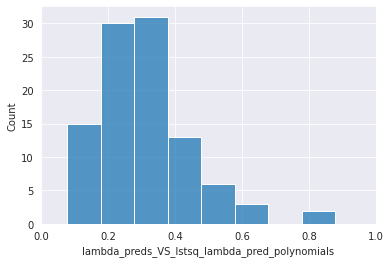

In [37]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


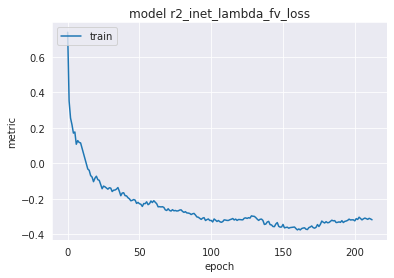

In [38]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


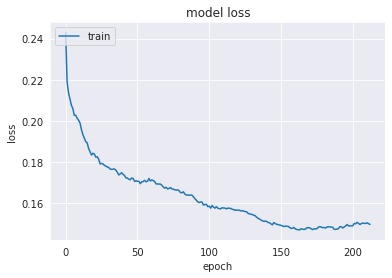

In [39]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [40]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [41]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [42]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [43]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


-0.4662*a**3 + 0.0383*a**2*b + 0.0479*a**2*c - 0.0525*a**2*d - 0.101*a**2*e + 0.1613*a**2 + 0.2409*a*b**2 + 0.1992*a*b*c - 0.0022*a*b*d + 0.6681*a*b*e - 0.0329*a*b - 0.0918*a*c**2 - 0.033*a*c*d + 0.011*a*c*e - 0.0632*a*c - 0.0196*a*d**2 + 0.0751*a*d*e + 0.0784*a*d - 0.0077*a*e**2 - 0.0466*a*e - 0.0924*a - 0.0141*b**3 + 0.0342*b**2*c + 0.1255*b**2*d + 0.0241*b**2*e - 0.0707*b**2 + 0.2112*b*c**2 + 0.0394*b*c*d - 0.0359*b*c*e - 0.1167*b*c + 0.0122*b*d**2 - 0.0274*b*d*e - 0.0653*b*d - 0.0575*b*e**2 + 0.0402*b*e + 0.0333*b - 0.2824*c**3 - 0.4325*c**2*d - 0.0786*c**2*e + 0.0327*c**2 - 0.0069*c*d**2 + 0.5187*c*d*e + 0.1074*c*d + 0.1152*c*e**2 + 0.0137*c*e + 0.0691*c - 0.0134*d**3 + 0.0176*d**2*e - 0.085*d**2 + 0.0116*d*e**2 + 0.0175*d*e + 0.0421*d + 0.0219*e**3 - 0.0575*e**2 - 0.0467*e + 0.0039

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_target_polynomials


-0.4752*a**3 + 0.4272*a*b**2 + 0.7819*a*b*e - 0.6492*c**2*d + 0.5495*c*d*e

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target_polynomials


-0.4752*a**3 + 0.4272*a*b**2 + 0.7819*a*b*e - 0.6492*c**2*d + 0.5495*c*d*e

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


1.00139999389648*a*d - 0.267599999904633*a*e**2 + 0.00920000020414591*b**3 + 0.157700002193451*b*c*e - 0.412299990653992

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
metamodel_functions


1/(3.5593829218502e-19*exp(-2.63750315316912*X0**3*X1**3 - 2.44220699122458*X0**3*X2**3 - 3.11035570741002*X0**3*X3**3 + 5.81964721443309*X0**3*X4**3 - 4.96316598531718e-5*X0**3 + 5.8169834461185*X0**2*X1**2 + 5.07307599753578*X0**2*X2**2 + 6.92727110641749*X0**2*X3**2 - 13.0618551620725*X0**2*X4**2 - 0.00050185779037597*X0**2 - 4.7712120460491*X0*X1 - 3.43911932183929*X0*X2 - 5.83817596066304*X0*X3 + 12.1673316221956*X0*X4 + 5.21169001912304e-5*X0 - 1.70089520119444*X1**3*X2**3 - 1.84390129445166*X1**3*X3**3 + 48.7420173902716*X1**3*X4**3 - 6.08251325304582e-5*X1**3 + 3.246535848782*X1**2*X2**2 + 3.47682280867261*X1**2*X3**2 - 91.260287025794*X1**2*X4**2 - 0.000647133913426937*X1**2 - 1.52950965871055*X1*X2 - 1.52443702685789*X1*X3 + 59.9726460884865*X1*X4 + 6.74411905933472e-5*X1 - 2.09529987436192*X2**3*X3**3 - 0.509025888653641*X2**3*X4**3 - 8.83583396341901e-5*X2**3 + 4.06737930492035*X2**2*X3**2 + 0.438665617421947*X2**2*X4**2 - 0.00207502399628544*X2**2 - 2.07494176343898*X2*X3 

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
symbolic_regression_functions


X3 - 0.699

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
per_network_polynomials


1.63469994068146*a**3 + 0.452600002288818*a**2*b - 2.21700000762939*a**2 + 1.21659994125366*a*d**2 - 0.369899988174438*b*e

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


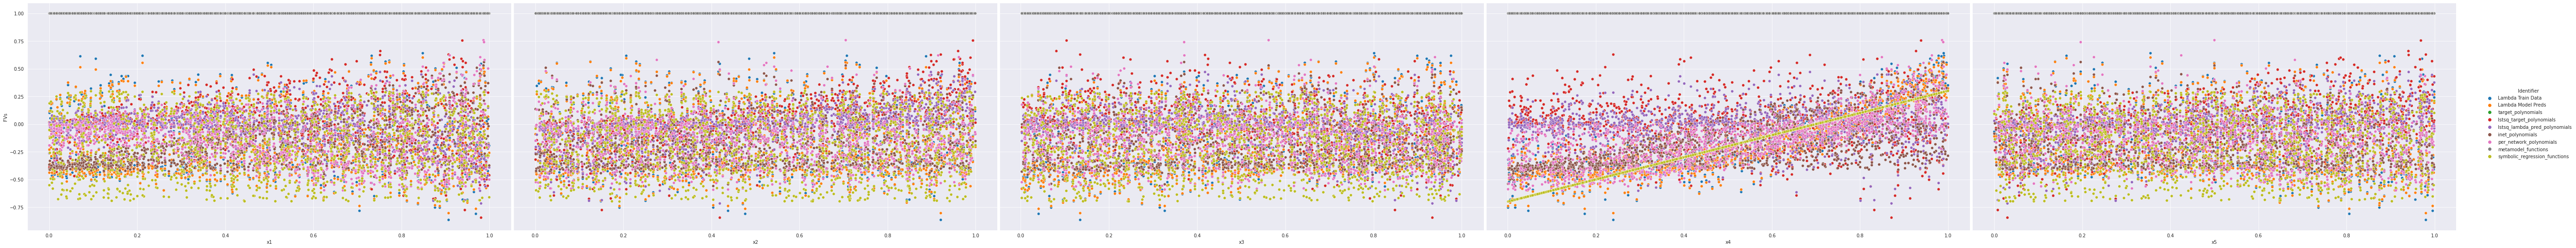

In [44]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

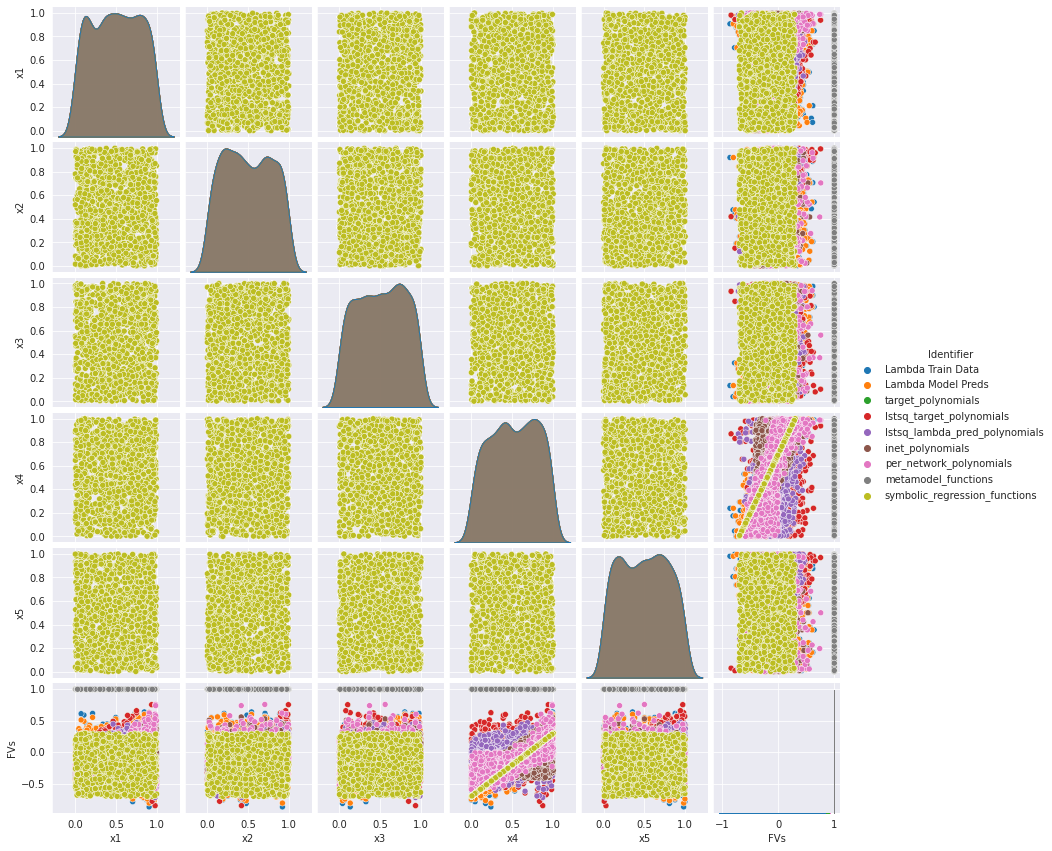

In [45]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

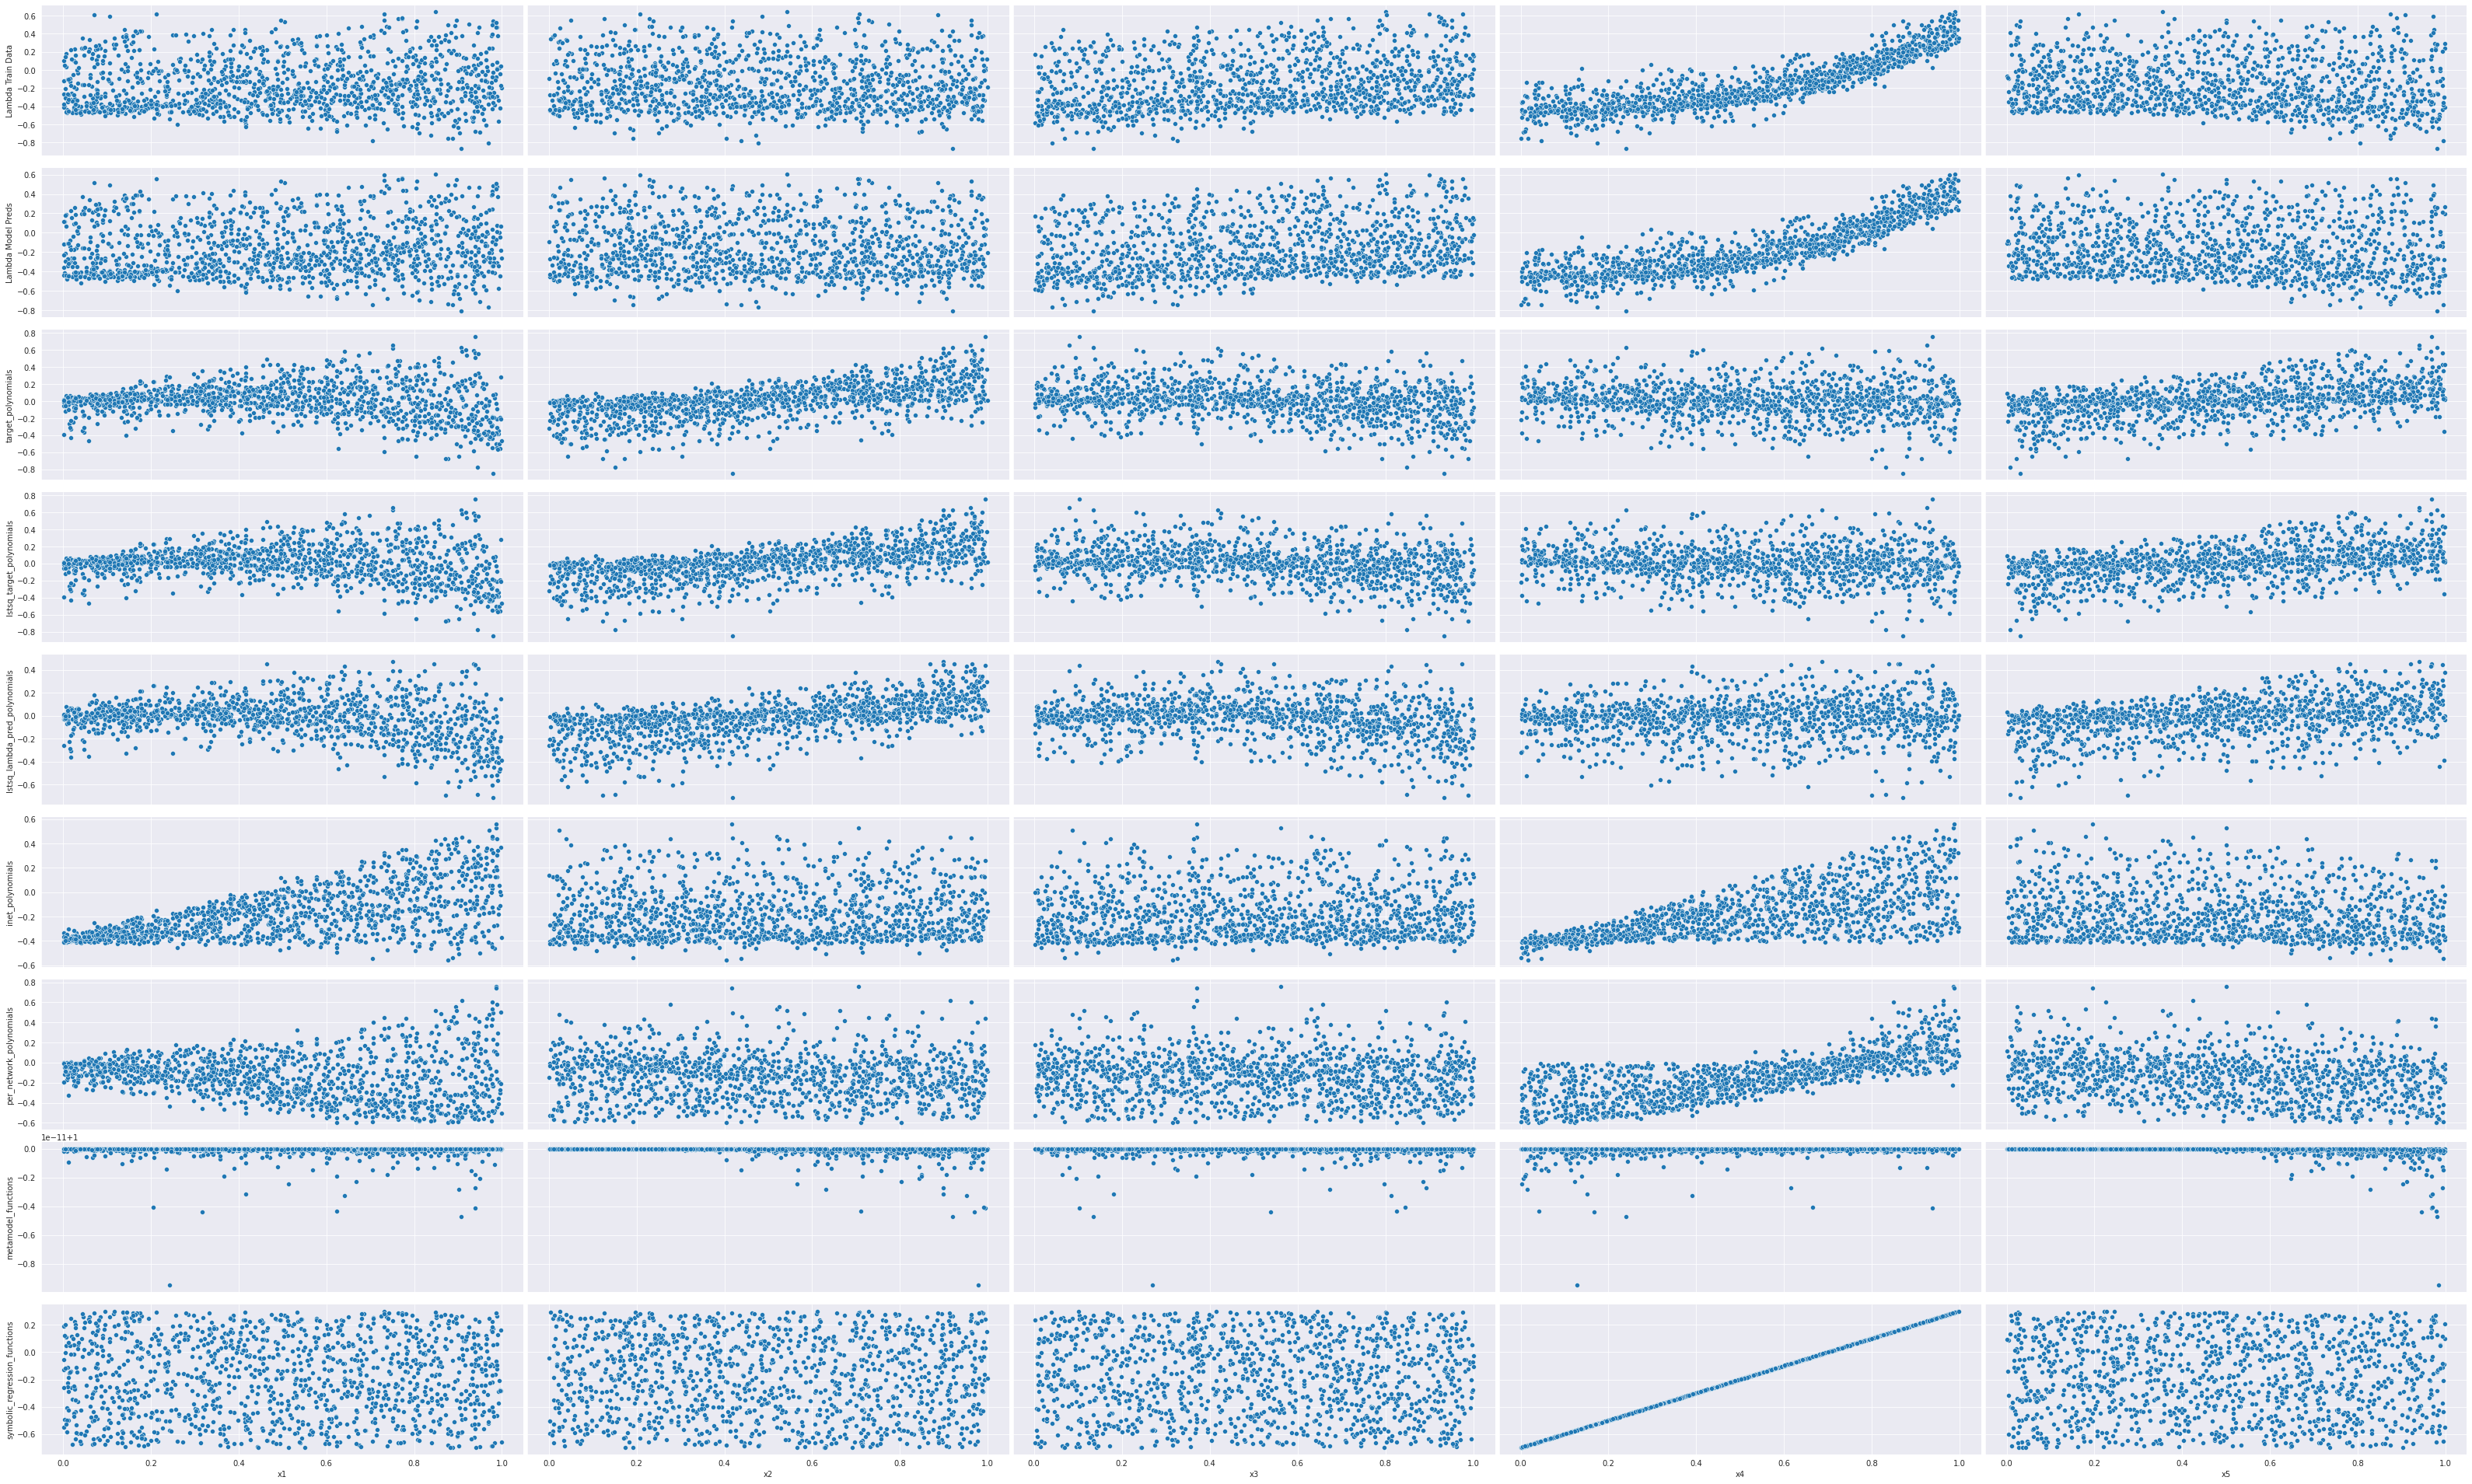

In [46]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

In [47]:
STOP

NameError: name 'STOP' is not defined

# BENCHMARK (RANDOM GUESS) EVALUATION

In [ ]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [ ]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [ ]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

In [ ]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [ ]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [ ]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

In [ ]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [ ]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


# Evaluate Real Dataset


##  Auto MPG-Dataset

In [ ]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [ ]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()